# Preparing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv', index_col = [0],  parse_dates = [0])
data.sort_index(ascending = True)
print(data.index.is_monotonic_increasing)

True


In [3]:
data.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [5]:
data = data.rename(columns={'meantemp': 'temperature'})

# EDA

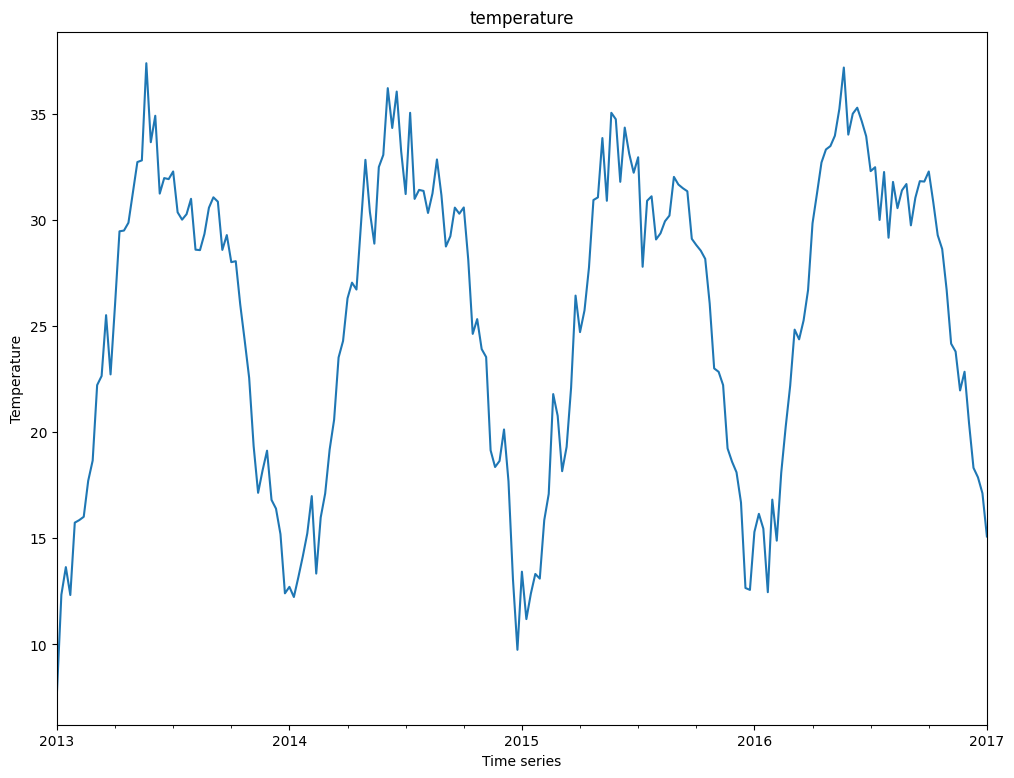

In [6]:
data = data.resample('1W').mean()
data['temperature'].plot(figsize = (12, 9), title = 'temperature')
plt.xlabel('Time series')
plt.ylabel('Temperature');

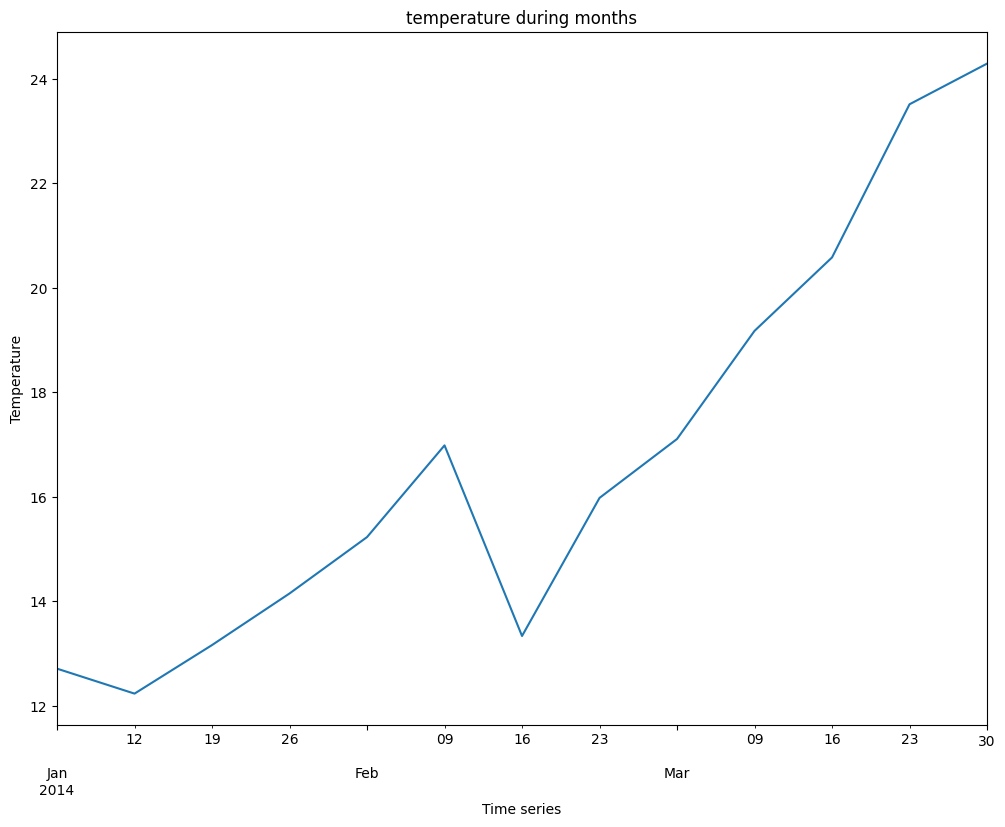

In [7]:
data_month = data['2014-01-01' : '2014-04-01']
data_month['temperature'].plot(figsize = (12, 9), title = 'temperature during months')
plt.xlabel('Time series')
plt.ylabel('Temperature');

In [8]:
data.isnull().sum()

temperature     0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [9]:
decomposed_data = seasonal_decompose(data['temperature'])

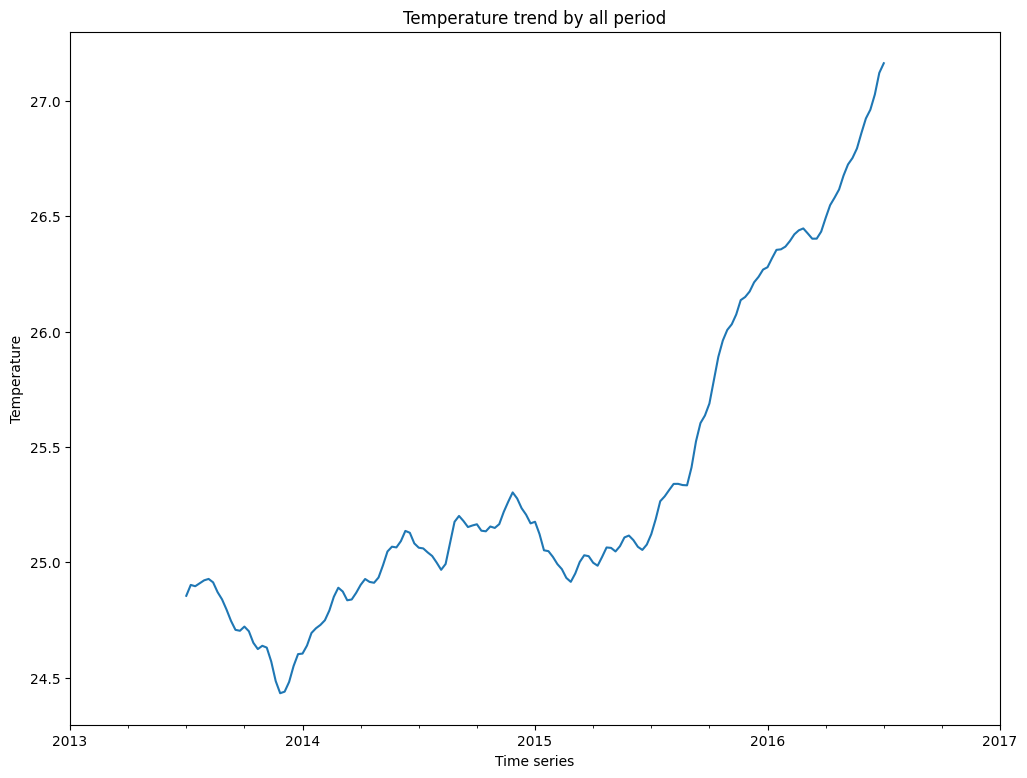

In [10]:
decomposed_data.trend.plot(figsize = (12, 9), title = 'Temperature trend by all period')
plt.ylabel('Temperature')
plt.xlabel('Time series');

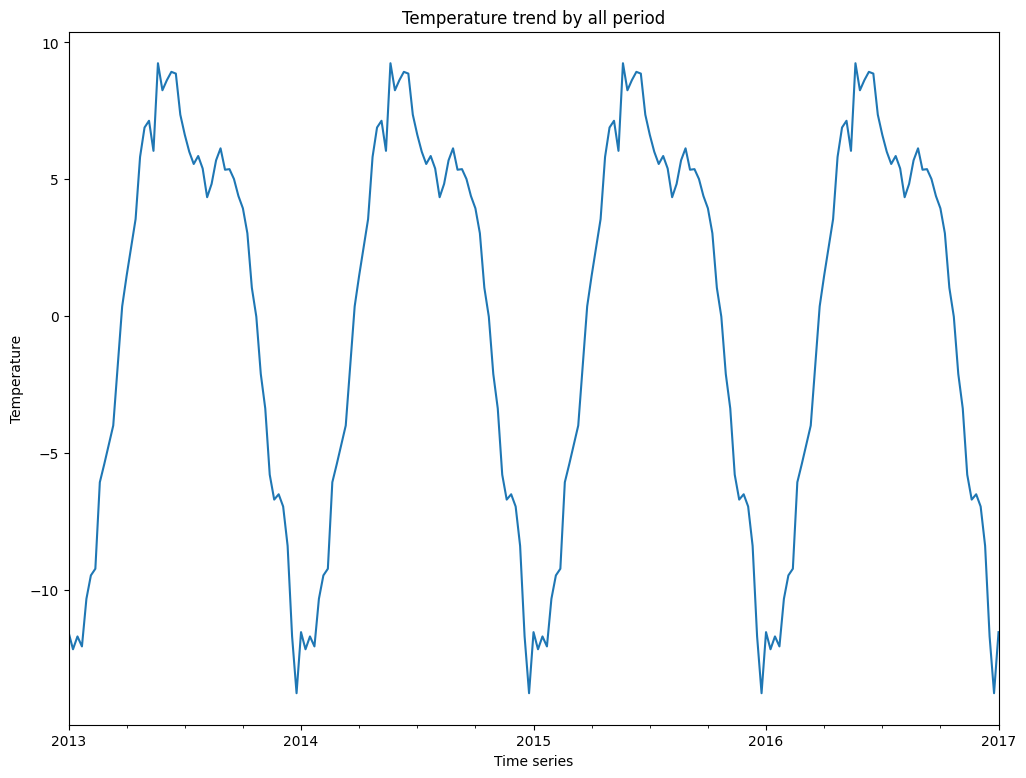

In [11]:
decomposed_data.seasonal.plot(figsize = (12, 9), title = 'Temperature trend by all period')
plt.ylabel('Temperature')
plt.xlabel('Time series');

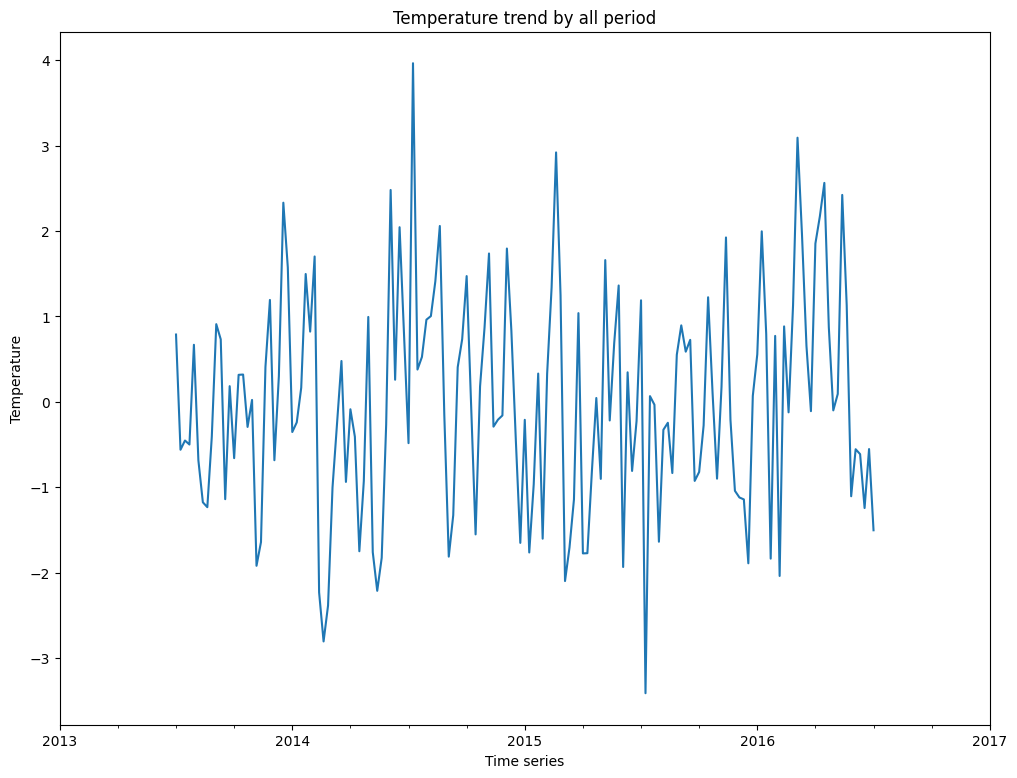

In [12]:
decomposed_data.resid.plot(figsize = (12, 9), title = 'Temperature trend by all period')
plt.ylabel('Temperature')
plt.xlabel('Time series');

In [13]:
data_shift = data - data.shift()
data_shift['mean'] = data_shift['temperature'].rolling(15).mean()
data_shift['std'] = data_shift['temperature'].rolling(15).std()

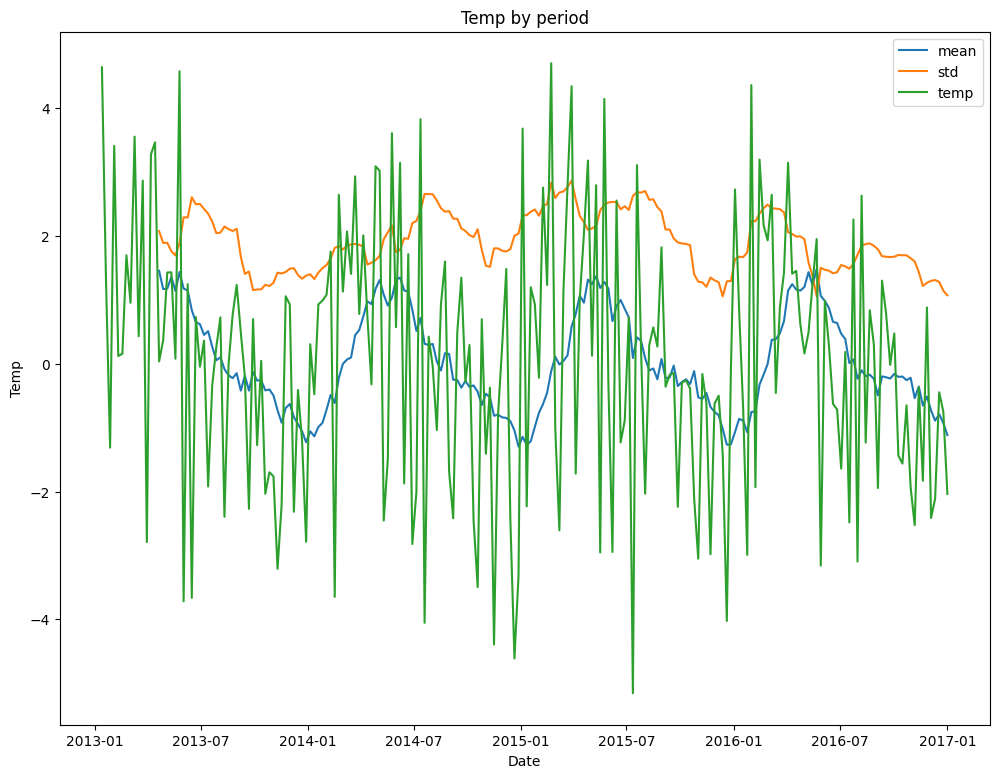

In [14]:
fig, ax = plt.subplots(figsize = (12, 9))
ax.plot(data_shift['mean'])
ax.plot(data_shift['std'])
ax.plot(data_shift['temperature'])
ax.legend(['mean', 'std', 'temp'])
ax.set_xlabel('Date')
ax.set_ylabel('Temp')
ax.set_title("Temp by period");

In [15]:
max_lag = 24
rolling_mean_size = 48

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['temperature'].shift(lag)

    data['rolling_mean'] = data['temperature'].shift().rolling(rolling_mean_size).mean()

In [16]:
data_ready = data.copy()

In [17]:
print(data_ready)

            temperature   humidity  wind_speed  meanpressure
date                                                        
2013-01-06     7.705556  84.077778    2.337778   1017.300000
2013-01-13    12.343537  65.145238    8.825170   1016.632653
2013-01-20    13.642857  81.663265    4.242857   1017.139456
2013-01-27    12.329592  67.748299    4.770544   1020.337075
2013-02-03    15.736905  67.667347    2.337194   1017.020578
...                 ...        ...         ...           ...
2016-12-04    20.428841  62.631290    4.839643    873.901783
2016-12-11    18.318229  70.672236    3.075850   1015.619483
2016-12-18    17.871140  61.808297    5.955406   1016.727185
2016-12-25    17.123006  66.346011    9.636147   1014.901237
2017-01-01    15.085173  82.139204    5.751243   1016.661017

[209 rows x 4 columns]


In [18]:
make_features(data_ready, max_lag, rolling_mean_size)

train, remain = train_test_split(data_ready, shuffle = False, test_size = 0.2)
valid, test = train_test_split(remain, shuffle = False, test_size = 0.5)
train = train.dropna()

features_train = train.drop(['temperature'], axis = 1)
target_train = train['temperature']

features_valid = valid.drop(['temperature'], axis = 1)
target_valid = valid['temperature']

features_test = test.drop(['temperature'], axis = 1)
target_test = test['temperature']

# Models

## LightGBM

In [19]:
model_LGBM = LGBMRegressor(n_estimators = 100)
tscv = TimeSeriesSplit(n_splits=5).split(features_train)

params_lgbm = {
    'max_depth' : [2, 4, 6],
    'n_estimators' : [100, 250],
    'verbose': [-1]
}


model_LGBM_GS = GridSearchCV(
    estimator = model_LGBM,
    param_grid = params_lgbm,
    scoring = 'neg_root_mean_squared_error',
    cv = tscv
)

model_LGBM_GS.fit(features_train, target_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x79d406069690>,
             estimator=LGBMRegressor(),
             param_grid={'max_depth': [2, 4, 6], 'n_estimators': [100, 250],
                         'verbose': [-1]},
             scoring='neg_root_mean_squared_error')

In [20]:
%%time
lgbm_best_params = model_LGBM_GS.best_params_
predict_LGBM = model_LGBM_GS.predict(features_valid)
lgbm_score = model_LGBM_GS.best_score_ * -1
print(lgbm_best_params)
print(lgbm_score)

{'max_depth': 2, 'n_estimators': 100, 'verbose': -1}
4.360022718234569
CPU times: user 2.22 ms, sys: 1.85 ms, total: 4.07 ms
Wall time: 5.43 ms


## CatBoost

In [21]:
%%time

tscv = TimeSeriesSplit(n_splits=5).split(features_train)
CB_model = CatBoostRegressor()

cat_params = {
    'depth' : [2, 4, 6],
    'n_estimators' : [100, 250]
               }

cat_GS = GridSearchCV(CB_model, 
                       cat_params, 
                       scoring = 'neg_root_mean_squared_error', 
                       cv = tscv)

cat_GS.fit(features_train, target_train, verbose=100)

Learning rate set to 0.147657
0:	learn: 5.9347653	total: 60.6ms	remaining: 6s
99:	learn: 0.1783819	total: 76.2ms	remaining: 0us
Learning rate set to 0.161908
0:	learn: 6.9058656	total: 407us	remaining: 40.3ms
99:	learn: 0.3216581	total: 18.9ms	remaining: 0us
Learning rate set to 0.171545
0:	learn: 7.0209837	total: 392us	remaining: 38.8ms
99:	learn: 0.4942339	total: 22.8ms	remaining: 0us
Learning rate set to 0.178945
0:	learn: 6.8257685	total: 559us	remaining: 55.4ms
99:	learn: 0.6803381	total: 26.4ms	remaining: 0us
Learning rate set to 0.185003
0:	learn: 6.4637341	total: 448us	remaining: 44.4ms
99:	learn: 0.6608138	total: 30.7ms	remaining: 0us
Learning rate set to 0.070102
0:	learn: 6.2260947	total: 378us	remaining: 94.2ms
100:	learn: 0.6655191	total: 16.1ms	remaining: 23.7ms
200:	learn: 0.2232143	total: 32.5ms	remaining: 7.91ms
249:	learn: 0.1431067	total: 40.9ms	remaining: 0us
Learning rate set to 0.076867
0:	learn: 7.3839746	total: 350us	remaining: 87.3ms
100:	learn: 0.6953332	total

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x79d406069bd0>,
             estimator=<catboost.core.CatBoostRegressor object at 0x79d401ee1ea0>,
             param_grid={'depth': [2, 4, 6], 'n_estimators': [100, 250]},
             scoring='neg_root_mean_squared_error')

In [22]:
%%time
cat_best_params = cat_GS.best_params_
predict_cat = cat_GS.predict(features_valid)
cat_score = cat_GS.best_score_ * -1
print(cat_best_params)
print(cat_score)

{'depth': 2, 'n_estimators': 250}
3.0652100490537477
CPU times: user 4.79 ms, sys: 965 µs, total: 5.75 ms
Wall time: 4.3 ms


## LinearRegression

In [23]:
%%time
tscv = TimeSeriesSplit(n_splits = 5).split(features_train)
LR = LinearRegression(copy_X = True, fit_intercept = True, n_jobs = None)
LR.fit(features_train, target_train)
LR_cv_score = pd.Series(cross_val_score(LR, features_train, target_train, scoring = 'neg_root_mean_squared_error', cv = tscv)).mean()*(-1)
print('Среднее качество модели на кросс-валидации:', LR_cv_score)

Среднее качество модели на кросс-валидации: 5.251461715876853
CPU times: user 53.2 ms, sys: 2.85 ms, total: 56.1 ms
Wall time: 72.2 ms


In [24]:
LR_valid_pred = LR.predict(features_valid)
rmse_valid = round(mean_squared_error(target_valid, LR_valid_pred) ** 0.5, 3)
print('RMSE модели Линейной регрессии:', rmse_valid )

RMSE модели Линейной регрессии: 72.017
